In [1]:
#imports
import csv
import numpy as np
import pandas as pd
import tensorflow as tf
from sklearn.model_selection import train_test_split

In [2]:
device_name = tf.test.gpu_device_name()
if device_name != '/device:GPU:0':
  raise SystemError('GPU device not found')
print('Found GPU at: {}'.format(device_name))

Found GPU at: /device:GPU:0


#### Modelo y dataset a utilizar

In [3]:
RANDOM_SEED = 42

dataset = 'https://raw.githubusercontent.com/ZeroHoushou/ProjectManin/master/model/keypoint_classifier/datasetDeGestos_v4.1.csv' #dataset a utilizar

model_save_path = 'model/keypoint_classifier/datasetDeGestos_v4.1.hdf5' #ruta donde guardar
tflite_save_path = 'model/keypoint_classifier/keypoint_classifier.tflite'
NUM_CLASSES = 5 #numero de clases

In [4]:
TIME_STEPS = 21
DIMENSION = 2

####  Cargando datasets (paramteros X y Y) para el testing y training

In [5]:
X_dataset = np.loadtxt(dataset, delimiter=',', dtype='float32', usecols=list(range(1, (TIME_STEPS * DIMENSION) + 1)))

In [6]:
y_dataset = np.loadtxt(dataset, delimiter=',', dtype='int32', usecols=(0))

In [7]:
X_train, X_test, y_train, y_test = train_test_split(X_dataset, y_dataset, train_size=0.75, random_state=RANDOM_SEED)

(array([0, 1, 2, 3, 4]), array([1522, 1572, 1356,  634,  900], dtype=int64))


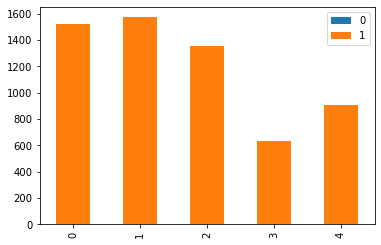

In [8]:
# Classes count
counts = np.unique(y_dataset, return_counts=True)
df = pd.DataFrame(counts)
df.T.plot(kind="bar", stacked=True)
print(counts)

## Estructura del modelo

In [9]:
use_old_model = False
model = None

if use_old_model:
    model = tf.keras.models.Sequential([
        tf.keras.layers.Input((21 * 2, )),
        tf.keras.layers.Dropout(0.2),
        tf.keras.layers.Dense(20, activation='relu'),
        tf.keras.layers.Dropout(0.4),
        tf.keras.layers.Dense(10, activation='relu'),
        tf.keras.layers.Dense(NUM_CLASSES, activation='softmax')
    ])
else:
    model = tf.keras.models.Sequential([
        tf.keras.layers.InputLayer(input_shape=(TIME_STEPS * DIMENSION, )),
        tf.keras.layers.Dropout(0.0),
        tf.keras.layers.Dense(32, activation='relu'),
        tf.keras.layers.Dropout(0.2),
        tf.keras.layers.Dense(32, activation='relu'),
        tf.keras.layers.Dropout(0.5),
        tf.keras.layers.Dense(16, activation='relu'),
        tf.keras.layers.Dense(NUM_CLASSES, activation='softmax')
    ])


In [10]:
model.summary() 

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 dropout (Dropout)           (None, 42)                0         
                                                                 
 dense (Dense)               (None, 32)                1376      
                                                                 
 dropout_1 (Dropout)         (None, 32)                0         
                                                                 
 dense_1 (Dense)             (None, 32)                1056      
                                                                 
 dropout_2 (Dropout)         (None, 32)                0         
                                                                 
 dense_2 (Dense)             (None, 16)                528       
                                                                 
 dense_3 (Dense)             (None, 5)                 8

In [11]:
cp_callback = tf.keras.callbacks.ModelCheckpoint(model_save_path, verbose=1, save_weights_only=False, save_best_only=True)
es_callback = tf.keras.callbacks.EarlyStopping(patience=50, verbose=1)

In [12]:
# compilación del modelo
model.compile(
    optimizer='adam',
    loss='sparse_categorical_crossentropy',
    metrics=['accuracy']
)

# Training del modelo con el dataset

In [13]:
model.fit(
    X_train,
    y_train,
    epochs=1000,
    batch_size=128,
    validation_data=(X_test, y_test),
    callbacks=[cp_callback, es_callback]
)

Epoch 1/1000
32/36 [=========================>....] - ETA: 0s - loss: 1.6320 - accuracy: 0.2285
Epoch 1: val_loss improved from inf to 1.49476, saving model to model/keypoint_classifier\datasetDeGestos_v4.1.hdf5
36/36 [==============================] - 9s 29ms/step - loss: 1.6237 - accuracy: 0.2344 - val_loss: 1.4948 - val_accuracy: 0.3984
Epoch 2/1000
34/36 [===========================>..] - ETA: 0s - loss: 1.4784 - accuracy: 0.3219
Epoch 2: val_loss improved from 1.49476 to 1.36523, saving model to model/keypoint_classifier\datasetDeGestos_v4.1.hdf5
36/36 [==============================] - 0s 11ms/step - loss: 1.4766 - accuracy: 0.3233 - val_loss: 1.3652 - val_accuracy: 0.3977
Epoch 3/1000
32/36 [=========================>....] - ETA: 0s - loss: 1.3736 - accuracy: 0.3792
Epoch 3: val_loss improved from 1.36523 to 1.22596, saving model to model/keypoint_classifier\datasetDeGestos_v4.1.hdf5
36/36 [==============================] - 0s 10ms/step - loss: 1.3711 - accuracy: 0.3783 - val_lo

36/36 [==============================] - 0s 11ms/step - loss: 0.3185 - accuracy: 0.8937 - val_loss: 0.1492 - val_accuracy: 0.9672
Epoch 25/1000
34/36 [===========================>..] - ETA: 0s - loss: 0.3059 - accuracy: 0.9129
Epoch 25: val_loss improved from 0.14919 to 0.14280, saving model to model/keypoint_classifier\datasetDeGestos_v4.1.hdf5
36/36 [==============================] - 0s 10ms/step - loss: 0.3060 - accuracy: 0.9131 - val_loss: 0.1428 - val_accuracy: 0.9686
Epoch 26/1000
36/36 [==============================] - ETA: 0s - loss: 0.2938 - accuracy: 0.9042
Epoch 26: val_loss improved from 0.14280 to 0.13828, saving model to model/keypoint_classifier\datasetDeGestos_v4.1.hdf5
36/36 [==============================] - 0s 10ms/step - loss: 0.2938 - accuracy: 0.9042 - val_loss: 0.1383 - val_accuracy: 0.9713
Epoch 27/1000
35/36 [============================>.] - ETA: 0s - loss: 0.2990 - accuracy: 0.9076
Epoch 27: val_loss improved from 0.13828 to 0.13369, saving model to model/ke

Epoch 50/1000
32/36 [=========================>....] - ETA: 0s - loss: 0.1814 - accuracy: 0.9500
Epoch 50: val_loss improved from 0.08253 to 0.08051, saving model to model/keypoint_classifier\datasetDeGestos_v4.1.hdf5
36/36 [==============================] - 0s 10ms/step - loss: 0.1839 - accuracy: 0.9483 - val_loss: 0.0805 - val_accuracy: 0.9840
Epoch 51/1000
33/36 [==========================>...] - ETA: 0s - loss: 0.1795 - accuracy: 0.9472
Epoch 51: val_loss improved from 0.08051 to 0.07948, saving model to model/keypoint_classifier\datasetDeGestos_v4.1.hdf5
36/36 [==============================] - 0s 10ms/step - loss: 0.1759 - accuracy: 0.9485 - val_loss: 0.0795 - val_accuracy: 0.9840
Epoch 52/1000
36/36 [==============================] - ETA: 0s - loss: 0.1750 - accuracy: 0.9470
Epoch 52: val_loss improved from 0.07948 to 0.07746, saving model to model/keypoint_classifier\datasetDeGestos_v4.1.hdf5
36/36 [==============================] - 0s 10ms/step - loss: 0.1750 - accuracy: 0.947

Epoch 77/1000
35/36 [============================>.] - ETA: 0s - loss: 0.1224 - accuracy: 0.9647
Epoch 77: val_loss did not improve from 0.06228
36/36 [==============================] - 0s 8ms/step - loss: 0.1222 - accuracy: 0.9648 - val_loss: 0.0647 - val_accuracy: 0.9873
Epoch 78/1000
36/36 [==============================] - ETA: 0s - loss: 0.1257 - accuracy: 0.9619
Epoch 78: val_loss did not improve from 0.06228
36/36 [==============================] - 0s 8ms/step - loss: 0.1257 - accuracy: 0.9619 - val_loss: 0.0670 - val_accuracy: 0.9873
Epoch 79/1000
33/36 [==========================>...] - ETA: 0s - loss: 0.1299 - accuracy: 0.9650
Epoch 79: val_loss did not improve from 0.06228
36/36 [==============================] - 0s 9ms/step - loss: 0.1306 - accuracy: 0.9641 - val_loss: 0.0672 - val_accuracy: 0.9886
Epoch 80/1000
36/36 [==============================] - ETA: 0s - loss: 0.1294 - accuracy: 0.9617
Epoch 80: val_loss did not improve from 0.06228
36/36 [==========================

36/36 [==============================] - ETA: 0s - loss: 0.1092 - accuracy: 0.9661
Epoch 105: val_loss did not improve from 0.04950
36/36 [==============================] - 0s 8ms/step - loss: 0.1092 - accuracy: 0.9661 - val_loss: 0.0589 - val_accuracy: 0.9893
Epoch 106/1000
33/36 [==========================>...] - ETA: 0s - loss: 0.1108 - accuracy: 0.9716
Epoch 106: val_loss did not improve from 0.04950
36/36 [==============================] - 0s 9ms/step - loss: 0.1107 - accuracy: 0.9715 - val_loss: 0.0558 - val_accuracy: 0.9893
Epoch 107/1000
35/36 [============================>.] - ETA: 0s - loss: 0.1155 - accuracy: 0.9656
Epoch 107: val_loss did not improve from 0.04950
36/36 [==============================] - 0s 8ms/step - loss: 0.1153 - accuracy: 0.9657 - val_loss: 0.0559 - val_accuracy: 0.9893
Epoch 108/1000
35/36 [============================>.] - ETA: 0s - loss: 0.1029 - accuracy: 0.9725
Epoch 108: val_loss did not improve from 0.04950
36/36 [==============================] -

34/36 [===========================>..] - ETA: 0s - loss: 0.0968 - accuracy: 0.9729
Epoch 134: val_loss did not improve from 0.04442
36/36 [==============================] - 0s 9ms/step - loss: 0.0952 - accuracy: 0.9733 - val_loss: 0.0548 - val_accuracy: 0.9900
Epoch 135/1000
34/36 [===========================>..] - ETA: 0s - loss: 0.0967 - accuracy: 0.9727
Epoch 135: val_loss did not improve from 0.04442
36/36 [==============================] - 0s 8ms/step - loss: 0.0964 - accuracy: 0.9726 - val_loss: 0.0516 - val_accuracy: 0.9893
Epoch 136/1000
35/36 [============================>.] - ETA: 0s - loss: 0.0903 - accuracy: 0.9681
Epoch 136: val_loss did not improve from 0.04442
36/36 [==============================] - 0s 8ms/step - loss: 0.0912 - accuracy: 0.9677 - val_loss: 0.0543 - val_accuracy: 0.9900
Epoch 137/1000
35/36 [============================>.] - ETA: 0s - loss: 0.1131 - accuracy: 0.9650
Epoch 137: val_loss did not improve from 0.04442
36/36 [==============================] -

36/36 [==============================] - 0s 8ms/step - loss: 0.0844 - accuracy: 0.9735 - val_loss: 0.0517 - val_accuracy: 0.9906
Epoch 164/1000
34/36 [===========================>..] - ETA: 0s - loss: 0.0916 - accuracy: 0.9745
Epoch 164: val_loss did not improve from 0.04335
36/36 [==============================] - 0s 8ms/step - loss: 0.0925 - accuracy: 0.9744 - val_loss: 0.0515 - val_accuracy: 0.9906
Epoch 165/1000
35/36 [============================>.] - ETA: 0s - loss: 0.0892 - accuracy: 0.9725
Epoch 165: val_loss did not improve from 0.04335
36/36 [==============================] - 0s 8ms/step - loss: 0.0893 - accuracy: 0.9724 - val_loss: 0.0522 - val_accuracy: 0.9900
Epoch 166/1000
35/36 [============================>.] - ETA: 0s - loss: 0.0786 - accuracy: 0.9752
Epoch 166: val_loss did not improve from 0.04335
36/36 [==============================] - 0s 8ms/step - loss: 0.0788 - accuracy: 0.9750 - val_loss: 0.0519 - val_accuracy: 0.9913
Epoch 167/1000
35/36 [=====================

Epoch 193/1000
34/36 [===========================>..] - ETA: 0s - loss: 0.0776 - accuracy: 0.9763
Epoch 193: val_loss did not improve from 0.04242
36/36 [==============================] - 0s 8ms/step - loss: 0.0774 - accuracy: 0.9766 - val_loss: 0.0478 - val_accuracy: 0.9913
Epoch 194/1000
35/36 [============================>.] - ETA: 0s - loss: 0.0712 - accuracy: 0.9808
Epoch 194: val_loss did not improve from 0.04242
36/36 [==============================] - 0s 8ms/step - loss: 0.0714 - accuracy: 0.9806 - val_loss: 0.0488 - val_accuracy: 0.9906
Epoch 195/1000
35/36 [============================>.] - ETA: 0s - loss: 0.0754 - accuracy: 0.9777
Epoch 195: val_loss did not improve from 0.04242
36/36 [==============================] - 0s 8ms/step - loss: 0.0752 - accuracy: 0.9777 - val_loss: 0.0572 - val_accuracy: 0.9900
Epoch 196/1000
34/36 [===========================>..] - ETA: 0s - loss: 0.0790 - accuracy: 0.9775
Epoch 196: val_loss did not improve from 0.04242
36/36 [==================

Epoch 222/1000
33/36 [==========================>...] - ETA: 0s - loss: 0.0794 - accuracy: 0.9761
Epoch 222: val_loss did not improve from 0.04044
36/36 [==============================] - 0s 7ms/step - loss: 0.0812 - accuracy: 0.9757 - val_loss: 0.0562 - val_accuracy: 0.9900
Epoch 223/1000
33/36 [==========================>...] - ETA: 0s - loss: 0.0591 - accuracy: 0.9804
Epoch 223: val_loss did not improve from 0.04044
36/36 [==============================] - 0s 9ms/step - loss: 0.0607 - accuracy: 0.9804 - val_loss: 0.0566 - val_accuracy: 0.9893
Epoch 224/1000
31/36 [========================>.....] - ETA: 0s - loss: 0.0694 - accuracy: 0.9806
Epoch 224: val_loss did not improve from 0.04044
36/36 [==============================] - 0s 8ms/step - loss: 0.0676 - accuracy: 0.9806 - val_loss: 0.0514 - val_accuracy: 0.9906
Epoch 225/1000
33/36 [==========================>...] - ETA: 0s - loss: 0.0662 - accuracy: 0.9782
Epoch 225: val_loss did not improve from 0.04044
36/36 [==================

Epoch 252/1000
32/36 [=========================>....] - ETA: 0s - loss: 0.0774 - accuracy: 0.9792
Epoch 252: val_loss did not improve from 0.04044
36/36 [==============================] - 0s 7ms/step - loss: 0.0767 - accuracy: 0.9793 - val_loss: 0.0424 - val_accuracy: 0.9920
Epoch 253/1000
31/36 [========================>.....] - ETA: 0s - loss: 0.0645 - accuracy: 0.9821
Epoch 253: val_loss did not improve from 0.04044
36/36 [==============================] - 0s 7ms/step - loss: 0.0617 - accuracy: 0.9828 - val_loss: 0.0472 - val_accuracy: 0.9906
Epoch 254/1000
31/36 [========================>.....] - ETA: 0s - loss: 0.0654 - accuracy: 0.9806
Epoch 254: val_loss did not improve from 0.04044
36/36 [==============================] - 0s 7ms/step - loss: 0.0647 - accuracy: 0.9808 - val_loss: 0.0468 - val_accuracy: 0.9920
Epoch 255/1000
33/36 [==========================>...] - ETA: 0s - loss: 0.0623 - accuracy: 0.9808
Epoch 255: val_loss did not improve from 0.04044
36/36 [==================

In [14]:
val_loss, val_acc = model.evaluate(X_test, y_test, batch_size=128)

12/12 [==============================] - 0s 6ms/step - loss: 0.0492 - accuracy: 0.9906


In [15]:
model = tf.keras.models.load_model(model_save_path)

In [16]:
predict_result = model.predict(np.array([X_test[1407]]))
print(np.squeeze(predict_result))
print(np.argmax(np.squeeze(predict_result)))

1/1 [==============================] - 0s 153ms/step
[3.6184298e-07 3.5865818e-07 8.0765431e-06 1.3955506e-07 9.9999106e-01]
4


# Validación y métricas

47/47 [==============================] - 0s 3ms/step


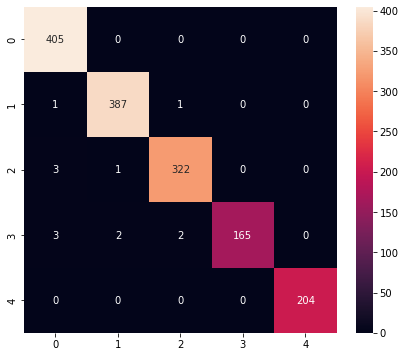

Classification Report
              precision    recall  f1-score   support

           0       0.98      1.00      0.99       405
           1       0.99      0.99      0.99       389
           2       0.99      0.99      0.99       326
           3       1.00      0.96      0.98       172
           4       1.00      1.00      1.00       204

    accuracy                           0.99      1496
   macro avg       0.99      0.99      0.99      1496
weighted avg       0.99      0.99      0.99      1496



In [17]:
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
from sklearn.metrics import confusion_matrix, classification_report

def print_confusion_matrix(y_true, y_pred, report=True):
    labels = sorted(list(set(y_true)))
    cmx_data = confusion_matrix(y_true, y_pred, labels=labels)
    
    df_cmx = pd.DataFrame(cmx_data, index=labels, columns=labels)
 
    fig, ax = plt.subplots(figsize=(7, 6))
    sns.heatmap(df_cmx, annot=True, fmt='g' ,square=False)
    ax.set_ylim(len(set(y_true)), 0)
    plt.show()
    
    if report:
        print('Classification Report')
        print(classification_report(y_test, y_pred))

Y_pred = model.predict(X_test)
y_pred = np.argmax(Y_pred, axis=1)

print_confusion_matrix(y_test, y_pred)

# Guardar modelo

In [18]:
model.save(model_save_path, include_optimizer=False)

In [19]:
print(X_test[1407])

[ 0.          0.         -0.08860759 -0.23206751 -0.08016878 -0.48101267
 -0.08860759 -0.7004219  -0.09704641 -0.8649789   0.3586498  -0.43881857
  0.5274262  -0.6919831   0.5864979  -0.8649789   0.62025315 -1.
  0.43459916 -0.3586498   0.4556962  -0.64978904  0.3206751  -0.6666667
  0.2278481  -0.62447256  0.44725737 -0.30379745  0.43881857 -0.5485232
  0.32911393 -0.556962    0.2658228  -0.51054853  0.443038   -0.2658228
  0.44725737 -0.45147678  0.3755274  -0.48523206  0.32489452 -0.47679326]


In [20]:
y_test[1407]

4

In [21]:
X_test.shape

(1496, 42)

In [22]:
# Transformazación de modelo (quantization)

converter = tf.lite.TFLiteConverter.from_keras_model(model)
converter.optimizations = [tf.lite.Optimize.DEFAULT]
tflite_quantized_model = converter.convert()

open(tflite_save_path, 'wb').write(tflite_quantized_model)

INFO:tensorflow:Assets written to: C:\Users\jhoan\AppData\Local\Temp\tmpjxueovd8\assets


7712

## Prueba de Inferencia

In [23]:
interpreter = tf.lite.Interpreter(model_path=tflite_save_path)
interpreter.allocate_tensors()

In [24]:
# Get I / O tensor
input_details = interpreter.get_input_details()
output_details = interpreter.get_output_details()

In [25]:
interpreter.set_tensor(input_details[0]['index'], np.array([X_test[0]]))

In [26]:
%%time
# Inference implementation
interpreter.invoke()
tflite_results = interpreter.get_tensor(output_details[0]['index'])

CPU times: total: 0 ns
Wall time: 6 ms


In [27]:
print(np.squeeze(tflite_results))
print(np.argmax(np.squeeze(tflite_results)))

[1.00000000e+00 1.47683865e-08 2.49000958e-19 6.63448896e-09
 4.23632352e-21]
0


# Tuneando hiperparametros 🚓

In [ ]:
%load_ext tensorboard
from tensorboard.plugins.hparams import api as hp

In [ ]:
# Inicializando parametro a tunear
HP_NUM_UNITS_1 = hp.HParam('num_units_1', hp.Discrete([16, 32, 64]))
HP_NUM_UNITS_2 = hp.HParam('num_units_2', hp.Discrete([8, 16, 32]))
HP_NUM_UNITS_3 = hp.HParam('num_units_3', hp.Discrete([8, 16, 32]))
HP_DROPOUT = hp.HParam('dropout', hp.RealInterval(0.0, 0.2))
HP_OPTIMIZER = hp.HParam('optimizer', hp.Discrete(['adam', 'sgd','nadam']))

METRIC_ACCURACY = 'accuracy'

In [ ]:
with tf.summary.create_file_writer('logs/hparam_tuning').as_default():
  hp.hparams_config(
    hparams=[HP_NUM_UNITS_1,HP_NUM_UNITS_2,HP_NUM_UNITS_3, HP_DROPOUT, HP_OPTIMIZER],
    metrics=[hp.Metric(METRIC_ACCURACY, display_name='Accuracy')],
  )

In [ ]:
# Model checkpoint callback
cp_callback = tf.keras.callbacks.ModelCheckpoint(
    model_save_path, verbose=1, save_weights_only=False, save_best_only=True)
# Callback for early stopping
es_callback = tf.keras.callbacks.EarlyStopping(patience=15, verbose=1)

In [ ]:
def train_test_model(hparams):

  model = tf.keras.models.Sequential([
    tf.keras.layers.Input((21 * 2, )),
    tf.keras.layers.Dropout(hparams[HP_DROPOUT]),
    tf.keras.layers.Dense(hparams[HP_NUM_UNITS_1], activation='relu'),
    tf.keras.layers.Dropout(hparams[HP_DROPOUT]),
    tf.keras.layers.Dense(hparams[HP_NUM_UNITS_2], activation='relu'),
    tf.keras.layers.Dropout(hparams[HP_DROPOUT]),
    tf.keras.layers.Dense(hparams[HP_NUM_UNITS_3], activation='relu'),
    tf.keras.layers.Dense(NUM_CLASSES, activation='softmax')
])
  
  model.compile(
    optimizer=hparams[HP_OPTIMIZER],
    loss='sparse_categorical_crossentropy',
    metrics=['accuracy']
)
  
  cp_callback = tf.keras.callbacks.ModelCheckpoint(
    model_save_path, verbose=1, save_weights_only=False, save_best_only=True)

  model.fit(
    X_train,
    y_train,
    epochs=50,
    batch_size=64,
    validation_data=(X_test, y_test),
    callbacks=[
               cp_callback,
               es_callback,
               ]
  ) 

  # Cargando modelo con el mejor acuracy
  model = tf.keras.models.load_model(model_save_path)

  _, accuracy = model.evaluate(X_test, y_test)
  return accuracy

def run(run_dir, hparams):
  with tf.summary.create_file_writer(run_dir).as_default():
    hp.hparams(hparams)  # registro de los valores usados en la puerba
    accuracy = train_test_model(hparams)
    tf.summary.scalar(METRIC_ACCURACY, accuracy, step=1)

In [ ]:
session_num = 0

for num_units_1 in HP_NUM_UNITS_1.domain.values:
  for num_units_2 in HP_NUM_UNITS_2.domain.values:
    for num_units_3 in HP_NUM_UNITS_3.domain.values:
      for dropout_rate in np.arange(HP_DROPOUT.domain.min_value, HP_DROPOUT.domain.max_value, 0.1):
        for optimizer in HP_OPTIMIZER.domain.values:
          hparams = {
              HP_NUM_UNITS_1: num_units_1,
              HP_NUM_UNITS_2: num_units_2,
              HP_NUM_UNITS_3: num_units_3,
              HP_DROPOUT: dropout_rate,
              HP_OPTIMIZER: optimizer,
          }
          run_name = "run-%d" % session_num
          print('--- Starting trial: %s' % run_name)
          print({h.name: hparams[h] for h in hparams})
          run('logs/hparam_tuning/' + run_name, hparams)
          session_num += 1

Se han truncado las últimas 5000 líneas del flujo de salida.
Epoch 19: val_loss improved from 0.80699 to 0.75593, saving model to model/keypoint_classifier/datasetDeGestos_v4.1.hdf5
71/71 [==============================] - 0s 5ms/step - loss: 0.9485 - accuracy: 0.6464 - val_loss: 0.7559 - val_accuracy: 0.8128
Epoch 20/50
60/71 [========================>.....] - ETA: 0s - loss: 0.9130 - accuracy: 0.6732
Epoch 20: val_loss improved from 0.75593 to 0.70880, saving model to model/keypoint_classifier/datasetDeGestos_v4.1.hdf5
71/71 [==============================] - 0s 5ms/step - loss: 0.9132 - accuracy: 0.6725 - val_loss: 0.7088 - val_accuracy: 0.8483
Epoch 21/50
64/71 [==========================>...] - ETA: 0s - loss: 0.8872 - accuracy: 0.6792
Epoch 21: val_loss improved from 0.70880 to 0.66847, saving model to model/keypoint_classifier/datasetDeGestos_v4.1.hdf5
71/71 [==============================] - 0s 6ms/step - loss: 0.8838 - accuracy: 0.6805 - val_loss: 0.6685 - val_accuracy: 0.8636

In [ ]:

%tensorboard --logdir logs/hparam_tuning

In [ ]:
import tensorflow as tf
print("Num GPUs Available: ", len(tf.config.list_physical_devices('GPU')))

Num GPUs Available:  1


In [ ]:
print(tf.config.list_physical_devices())

[PhysicalDevice(name='/physical_device:CPU:0', device_type='CPU'), PhysicalDevice(name='/physical_device:GPU:0', device_type='GPU')]
